In [100]:
from collections import defaultdict
import itertools
import random
import pandas as pd
from ceat import ceat_meta
import numpy as np
from embeddings import generate_embedding, generate_embedding_bulk, visualize_embeddings

Set random seed

In [101]:
random.seed(42)

# Use baby names dataset for choosing female, male and neutral names

In [163]:
def load_names_from_baby_names():
    
    # CSV file with columns "year","name","percent","sex", get the top 1000 names for "boy" and "girl"
    f = "baby-names.csv"
    
    # Load all data from the file
    data = pd.read_csv(f)
    # Sum each row for name and sex
    data = data.groupby( ["name", "sex"] ).sum().reset_index()
    # Sort by percent
    data = data.sort_values(by='percent', ascending=False)
    males = data[data["sex"] == "boy"]
    females = data[data["sex"] == "girl"]

    intersect = pd.merge(males, females, on=["name"], how="inner")
    # Filter intersect where 1.3 > percent_x/percent_y > 0.7
    intersect = intersect[(intersect["percent_x"]/intersect["percent_y"] > 0.80) & (intersect["percent_x"]/intersect["percent_y"] < 1.2)]
    # Sort by distance from 1 
    intersect["distance"] = abs(intersect["percent_x"]/intersect["percent_y"] - 1)
    intersect = intersect.sort_values(by='distance', ascending=True)

    # Assert that the sum of intersects percentages are 95% similar
    
    males_subset = males[:12]
    females_subset = females[:12]
    intersect_subset = intersect[:min(12,len(intersect))]
    print(f"Number of names in intersect: {len(intersect)}, {intersect_subset}")
    assert abs(intersect["percent_x"].sum() - intersect["percent_y"].sum()) / len(intersect) < 0.01

    # Return array of top 1000 names
    man_array = males_subset["name"].values
    female_array = females_subset["name"].values
    nonbinary_array = intersect_subset["name"].values
    return (man_array,female_array, nonbinary_array)

# Load occupations from occupations.csv, this is some list of occupations I found online.

In [164]:
def load_occupations(random_groups=False):
    f = "inc_occ_gender.csv"
    # Has format Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
    data = pd.read_csv(f)
    # Remove data where Occupation is all caps
    data = data[~data["Occupation"].str.isupper()]
    # Remove functions that have more than two twords
    data = data[data["Occupation"].apply(lambda x: len(x.split(" ")) <= 3)]
    
    # Sort by All_workers and get top 100
    data = data.sort_values(by='All_workers', ascending=False)
    data = data[:100]

    # Replace all plural words with singular
    # Add space after each occupation
    data["Occupation"] = data["Occupation"].apply(lambda x: x + " ")
    data["Occupation"] = data["Occupation"].apply(lambda x: x.replace("s "," "))
    # Remove trailing spaces
    data["Occupation"] = data["Occupation"].apply(lambda x: x.strip())    

    # Add a collumn that has M_workers/F_workers
    
    data["ratio"] = data["M_workers"] / data["F_workers"]
    # Sort by ratio
    if not random_groups:
        data = data.sort_values(by='ratio', ascending=False)

    # Get top occupations for both genders
    top_m = data[:10]["Occupation"].values
    top_f = data[-10:]["Occupation"].values

    # Also get top ten of most fair occupations
    data["distance"] = abs(data["ratio"] - 1)
    data = data.sort_values(by='distance', ascending=True)
    print(data[:10])
    top_fair = data[:10]["Occupation"].values
    return (top_m,top_f,top_fair) ,data
    

In [165]:
(MALE_NAMES,FEMALE_NAMES,NEUTRAL_NAMES) = load_names_from_baby_names()

Number of names in intersect: 22,          name sex_x  year_x  percent_x sex_y  year_y  percent_y  distance
268      Kris   boy   82593   0.006231  girl   56869   0.006354  0.019358
302     Maxie   boy  119417   0.004003  girl  109040   0.004174  0.040968
180     Kerry   boy  131793   0.025052  girl  108350   0.026162  0.042428
363     Devyn   boy   32008   0.002141  girl   31977   0.002246  0.046750
206    Peyton   boy   51321   0.013884  girl   34000   0.014670  0.053579
230      Gale   boy  139091   0.009868  girl   72224   0.010456  0.056236
514      Bird   boy   13193   0.000384  girl   11300   0.000409  0.061125
141    Jackie   boy  156920   0.049527  girl  175632   0.052820  0.062344
281   Justice   boy   35880   0.005240  girl   30015   0.004889  0.071794
186     Avery   boy  250776   0.022645  girl   39970   0.020847  0.086247
197   Kendall   boy  184371   0.016373  girl   63726   0.018150  0.097906
431  Kenyatta   boy   21725   0.000905  girl   15810   0.000815  0.110429


In [166]:
(MALE_OCUPATIONS,FEMALE_OCCUPATIONS, NEUTRAL_OCCUPATIONS), raw_OCCUPATION_DATA = load_occupations()
print(MALE_OCUPATIONS,FEMALE_OCCUPATIONS, NEUTRAL_OCCUPATIONS)
SENTENCE_TEMPLATES = [
    "{name} is a {attribute}",
    # "{name} is someone's {attribute}",
    "{name} works as a {attribute}",
    "{name} retired from being a {attribute}",
]

                     Occupation  All_workers All_weekly  M_workers M_weekly  \
153                    Designer          593        993        301     1099   
10            Financial manager         1124       1408        551     1732   
21         Food service manager          763        742        389      820   
285      Advertising sale agent          161        925         78     1155   
75   Operation research analyst          122       1441         59     1574   
176                  Pharmacist          206       1920         98     2117   
240     Food preparation worker          366        402        174      414   
446                       Baker          150        505         69      570   
165           Writer and author           79       1232         36       Na   
38           Compliance officer          235       1198        126     1375   

     F_workers F_weekly     ratio  distance  
153        291      918  1.034364  0.034364  
10         573     1130  0.961606  0.0

# Generate sentences and create a dataframe that has all sentences

In [167]:
def generate_sentences(names, attributes = pd.concat([pd.Series(MALE_OCUPATIONS),pd.Series(FEMALE_OCCUPATIONS), pd.Series(NEUTRAL_OCCUPATIONS)])):
    sentences = {}
    # Create all possible combinations of attribute, noun and sentence template
    triplets = list(itertools.product(attributes, names, SENTENCE_TEMPLATES))
    for (a, n, st) in triplets:
        sentence = st.format(name=n, attribute=a)
        sentences[(a,n,st)] = sentence
    return sentences

In [168]:
neutral_sentence_dict = generate_sentences(names=NEUTRAL_NAMES)
male_sentence_dict = generate_sentences(names=MALE_NAMES)
female_sentence_dict = generate_sentences(names=FEMALE_NAMES)

In [169]:
pd_neutral = pd.DataFrame([(k[0],k[1],k[2],v,"X") for k,v in neutral_sentence_dict.items()], columns=["attribute","name","sentence_template","sentence", "group"])
pd_f = pd.DataFrame([(k[0],k[1],k[2],v,"F") for k, v in female_sentence_dict.items()], columns=["attribute","name","sentence_template","sentence", "group"])
pd_m = pd.DataFrame([(k[0],k[1],k[2],v,"M") for k, v in male_sentence_dict.items()], columns=["attribute","name","sentence_template","sentence", "group"])

In [170]:
pd_all = pd.concat([pd_neutral,pd_f,pd_m])
pd_all = pd_all.reset_index()
pd_all.to_csv("dataset_pd_all.csv")

Print total sentence tokens

In [171]:
total_sentence_tokens = pd_all["sentence"].apply(lambda x: len(x.split(" "))).sum()
print(f"Total sentence tokens(make sure this is not too much for OpenAI): {total_sentence_tokens}")


Total sentence tokens(make sure this is not too much for OpenAI): 19440


# Acquire embeddings for all sentences, code can use some cleaning up

Create dictionary copy of pd_all

In [172]:
pd_all_to_dict = pd_all.to_dict(orient="index")

In [173]:
distinct_attributes = pd_all["attribute"].unique()
distinct_groups = pd_all["group"].unique()

In [174]:
for a in distinct_attributes:
    for g in distinct_groups:
        print(f"Attribute: {a}, Group: {g}")
        data_a_g = pd_all[(pd_all["attribute"] == a) & (pd_all["group"] == g)]
        
        embedding_str_pairs = generate_embedding_bulk(sentences=data_a_g["sentence"].values,save_to_file=True)
        assert len(embedding_str_pairs) == len(data_a_g)
        for ((i, row),(sentence, embedding)) in zip(data_a_g.iterrows(),embedding_str_pairs):
            assert row["sentence"] == sentence              

            # Store array in pd_all_to_dict
            pd_all_to_dict[i]["embedding"] = np.array(embedding)

Attribute: Highway maintenance worker, Group: X
From cache: 36, To compute: 0
Attribute: Highway maintenance worker, Group: F
From cache: 36, To compute: 0
Attribute: Highway maintenance worker, Group: M
From cache: 36, To compute: 0
Attribute: Roofer, Group: X
From cache: 36, To compute: 0
Attribute: Roofer, Group: F
From cache: 36, To compute: 0
Attribute: Roofer, Group: M
From cache: 36, To compute: 0
Attribute: Carpenter, Group: X
From cache: 36, To compute: 0
Attribute: Carpenter, Group: F
From cache: 36, To compute: 0
Attribute: Carpenter, Group: M
From cache: 36, To compute: 0
Attribute: Construction laborer, Group: X
From cache: 36, To compute: 0
Attribute: Construction laborer, Group: F
From cache: 36, To compute: 0
Attribute: Construction laborer, Group: M
From cache: 36, To compute: 0
Attribute: Electrician, Group: X


# Statistics on embeddings

In [ ]:
def get_cosine_similarity(a,avg_a_g):
    cos_x_f = np.dot(avg_a_g[("X",a)],avg_a_g[("F",a)]) / (np.linalg.norm(avg_a_g[("X",a)]) * np.linalg.norm(avg_a_g[("F",a)]))
    cos_x_m = np.dot(avg_a_g[("X",a)],avg_a_g[("M",a)]) / (np.linalg.norm(avg_a_g[("X",a)]) * np.linalg.norm(avg_a_g[("M",a)]))
    avg_a_g_fm = (avg_a_g[("F",a)] + avg_a_g[("M",a)]) / 2
    cos_x_fmmean = np.dot(avg_a_g[("X",a)],avg_a_g_fm) / (np.linalg.norm(avg_a_g[("X",a)]) * np.linalg.norm(avg_a_g_fm))
    print(f"Attribute: {a}, Cosine similarity between X and F: {cos_x_f}, Cosine similarity between X and M: {cos_x_m}")
    return (cos_x_f,cos_x_m, cos_x_fmmean)

In [ ]:
average_embedding_a_g = defaultdict(list)
for (i,row) in pd_all_to_dict.items():
    embedding = row["embedding"]
    average_embedding_a_g[(row["group"],row["attribute"])].append(embedding)

average_embedding_a_g = {k: np.mean(v,axis=0).squeeze() for k,v in average_embedding_a_g.items()}
print(f"Average embeddings per group: {average_embedding_a_g}")

Average embeddings per group: {('X', 'Managers, all other'): array([ 0.00710627, -0.00121239, -0.01073282, ...,  0.00278432,
        0.01293452, -0.00406716]), ('X', 'Registered nurse'): array([-0.00547403, -0.00053179, -0.00632016, ...,  0.00262916,
        0.01024636, -0.00994758]), ('X', 'Retail salesperson'): array([-0.01194258,  0.01269495, -0.00719816, ..., -0.0047175 ,
        0.00010273, -0.01212685]), ('X', 'Customer service representative'): array([-0.0081139 , -0.0070441 , -0.00566327, ..., -0.00792787,
        0.00031285, -0.01047785]), ('X', 'Accountant and auditor'): array([-0.00067438,  0.02026428, -0.00861513, ...,  0.00304744,
        0.00595125, -0.01634302]), ('X', 'Cashier'): array([-0.0165045 ,  0.01105127, -0.00576787, ..., -0.00966719,
        0.00044553, -0.01629202]), ('X', 'Cook'): array([ 0.01431638, -0.02381635, -0.01122135, ...,  0.00225917,
       -0.00407709, -0.00158515]), ('X', 'Construction laborer'): array([-0.00205438,  0.00903512, -0.00294233, ..., 

In [ ]:
cosine_similarities = {}
for a in distinct_attributes:
    (cos_x_f,cos_x_m, cos_x_fm) =get_cosine_similarity(a,average_embedding_a_g)
    cosine_similarities[a] = (cos_x_f,cos_x_m, cos_x_fm)

Attribute: Managers, all other, Cosine similarity between X and F: 0.9145754521798202, Cosine similarity between X and M: 0.9287353953081403
Attribute: Registered nurse, Cosine similarity between X and F: 0.9071891942970421, Cosine similarity between X and M: 0.8708424106522532
Attribute: Retail salesperson, Cosine similarity between X and F: 0.8878818886823278, Cosine similarity between X and M: 0.8747126752375801
Attribute: Customer service representative, Cosine similarity between X and F: 0.8853452558231674, Cosine similarity between X and M: 0.8750183048955766
Attribute: Accountant and auditor, Cosine similarity between X and F: 0.8949794888042053, Cosine similarity between X and M: 0.8959654115824317
Attribute: Cashier, Cosine similarity between X and F: 0.8979937625220463, Cosine similarity between X and M: 0.8826831920958214
Attribute: Cook, Cosine similarity between X and F: 0.8780306577651558, Cosine similarity between X and M: 0.8942087631915246
Attribute: Construction labor

## Plot cosine similarity of F and M to X per attribute 

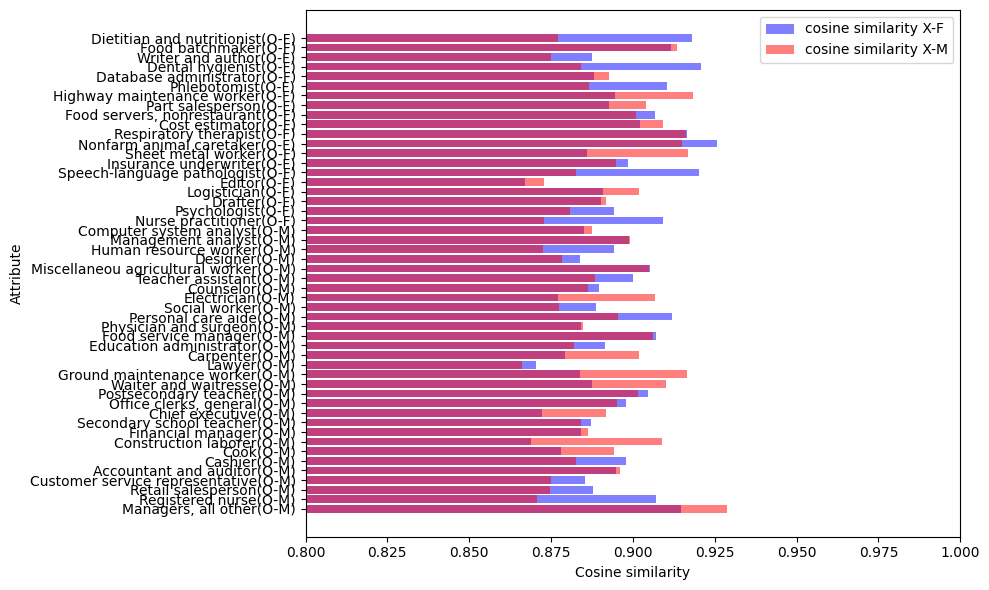

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the chart
def_get_group_of_key = lambda k: "O-F" if k in FEMALE_OCCUPATIONS else ("O-M" if k in MALE_OCUPATIONS else "O-X")

cos_keys = list([ k + f"({def_get_group_of_key(k)})" for k in cosine_similarities.keys()])
ax.barh(cos_keys, [v[0] for v in cosine_similarities.values()], color='b', alpha=0.5, label='cosine similarity X-F')
ax.barh(cos_keys, [v[1] for v in cosine_similarities.values()], color='r', alpha=0.5, label='cosine similarity X-M')
# ax.barh(cos_keys, [v[2] for v in cosine_similarities.values()], color='g', alpha=0.2, label='cosine similarity X-avg(F+M)')
ax.legend()
ax.set_xlabel("Cosine similarity")
ax.set_ylabel("Attribute")
plt.xlim(.8, 1)
# Adjust the layout to prevent labels from falling off
plt.tight_layout()
plt.savefig("cosine_similarities.png")


## Plot difference in cosine similarities against raw_OCCUPATION_DATA for employment ratio of males/ (total)

R^2: 0.6994464768527473


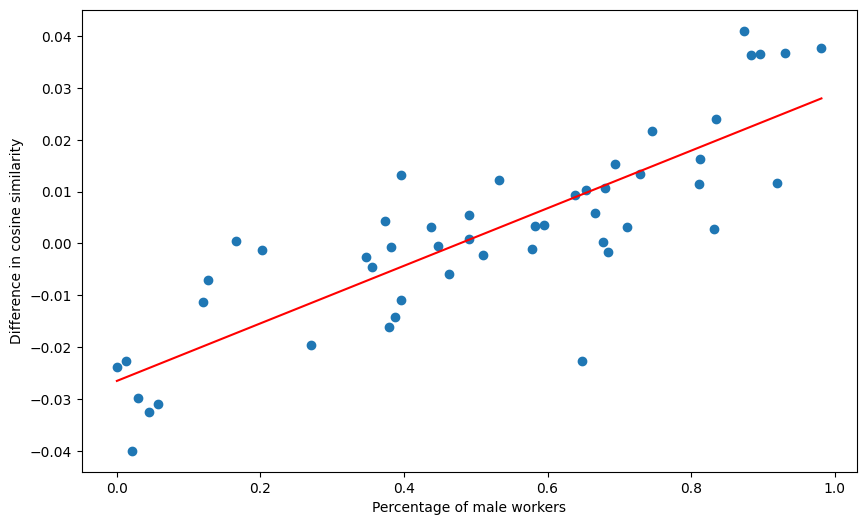

In [ ]:
from sklearn.linear_model import LinearRegression


fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the chart
key_data = [raw_OCCUPATION_DATA[raw_OCCUPATION_DATA["Occupation"] == a] for a in cosine_similarities.keys()]
male_ratio = [data["F_workers"].values[0] / data["All_workers"].values[0] for data in key_data]
ax.scatter(male_ratio, [v[0] - v[1] for v in cosine_similarities.values()])
ax.set_xlabel("Percentage of male workers")
ax.set_ylabel("Difference in cosine similarity")
# Display linear regression line of best fit
# Fit linear regression
X = np.array(male_ratio).reshape(-1, 1)
y = np.array([v[0] - v[1] for v in cosine_similarities.values()])
model = LinearRegression()
model.fit(X, y)
line_x = np.linspace(min(male_ratio), max(male_ratio), 100)
line_y = model.predict(line_x.reshape(-1, 1))

# get likelihood of the model
r_sq = model.score(X, y)
print(f"R^2: {r_sq}")


# Plot linear regression line
ax.plot(line_x, line_y, color='red')


plt.savefig("cosine_similarities_diff.png")

In [ ]:
sent2emb = defaultdict(list)
for emb in pd_all_to_dict.values():
    sent2emb[emb["name"]].append(emb["embedding"])
    sent2emb[emb["attribute"]].append(emb["embedding"])
print(ceat_meta([[FEMALE_NAMES,MALE_NAMES,FEMALE_OCCUPATIONS,MALE_OCUPATIONS]],sent2emb,N = 1000))

KeyboardInterrupt: 